## Load the Dataset

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("loan_data.csv")   # change name if needed
print(df.head())
print(df.shape)

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

## Check for Null Values

In [2]:
null_values = df.isnull().sum().sort_values(ascending=False)
print(null_values[null_values > 0])

COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
                             ...  
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
Length: 67, dtype: int64


## Percentage of Default vs Payer (TARGET Column)

In [11]:
target_counts = df["TARGET"].value_counts(normalize=True) * 100
print("Percentage Distribution:\n", target_counts)

Percentage Distribution:
 TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


## Balance the Dataset (Imbalanced Data)

In [18]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Separate numerical and categorical features
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

# Identify categorical columns (those with object or category dtype)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns

# One-hot encode categorical features
if len(categorical_cols) > 0:
    # Changed 'sparse=False' to 'sparse_output=False' to match newer scikit-learn versions
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_cats = encoder.fit_transform(X[categorical_cols])
    
    # Create DataFrame with proper column names for encoded features
    # This ensures all column names are strings
    feature_names = encoder.get_feature_names_out(categorical_cols)
    encoded_df = pd.DataFrame(encoded_cats, index=X.index, columns=feature_names)
    
    # Combine numerical features with encoded categorical features
    # No need to reset_index here which was causing issues
    X_processed = pd.concat([X[numerical_cols], encoded_df], axis=1)
else:
    X_processed = X[numerical_cols]

# Convert all column names to strings to ensure compatibility
X_processed.columns = X_processed.columns.astype(str)

# Apply SMOTE on the processed data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_processed, y)

print("Before:", y.value_counts())
print("After:", y_res.value_counts())

Before: TARGET
0    282686
1     24825
Name: count, dtype: int64
After: TARGET
1    282686
0    282686
Name: count, dtype: int64


 ## Plot Imbalanced and Balanced Data

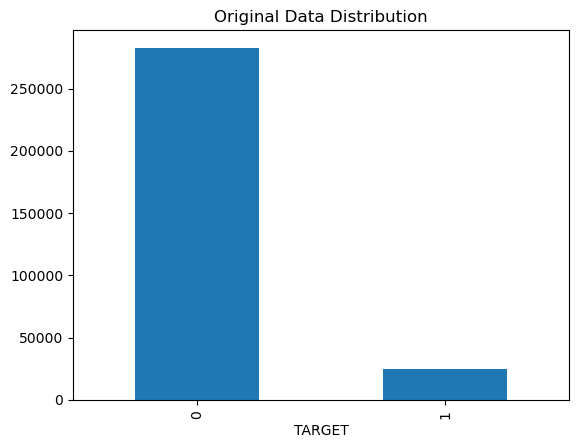

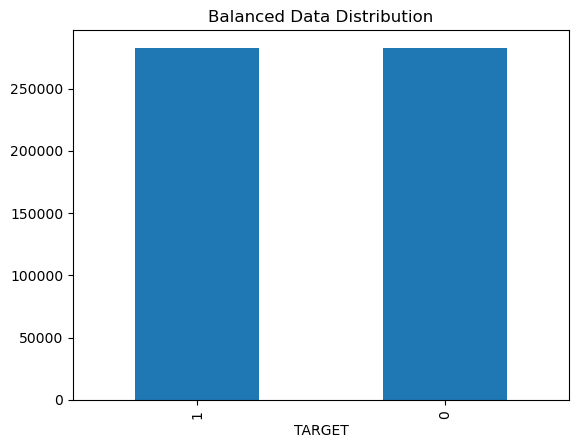

In [19]:
import matplotlib.pyplot as plt

plt.figure()
y.value_counts().plot(kind="bar")
plt.title("Original Data Distribution")
plt.show()

plt.figure()
y_res.value_counts().plot(kind="bar")
plt.title("Balanced Data Distribution")
plt.show()

## Encode Required Columns

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])

## Train-Test Split & Scaling

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("TARGET", axis=1)
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Build Deep Learning Mode

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64
)

C:\Users\vikra\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9193 - loss: 0.2652 - val_accuracy: 0.9177 - val_loss: 0.2575
Epoch 2/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9196 - loss: 0.2556 - val_accuracy: 0.9177 - val_loss: 0.2552
Epoch 3/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9196 - loss: 0.2537 - val_accuracy: 0.9177 - val_loss: 0.2556
Epoch 4/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9196 - loss: 0.2524 - val_accuracy: 0.9177 - val_loss: 0.2549
Epoch 5/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9196 - loss: 0.2515 - val_accuracy: 0.9178 - val_loss: 0.2544
Epoch 6/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9197 - loss: 0.2509 - val_accuracy: 0.9177 - val_loss: 0.2551
Epoch 7/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9197 - loss: 0.2503 - val_accuracy: 0.9177 - val_loss: 0.2550
Epoch 8/20
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9196 - loss: 0

## Predictions

In [23]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [27]:
## Sensitivity (Recall for Default = 1)

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
print("Sensitivity (Recall for Default):", sensitivity)

Sensitivity (Recall for Default): 0.0034239677744209466


## ROC Curve & AUC

AUC Score: 0.7413153402481276


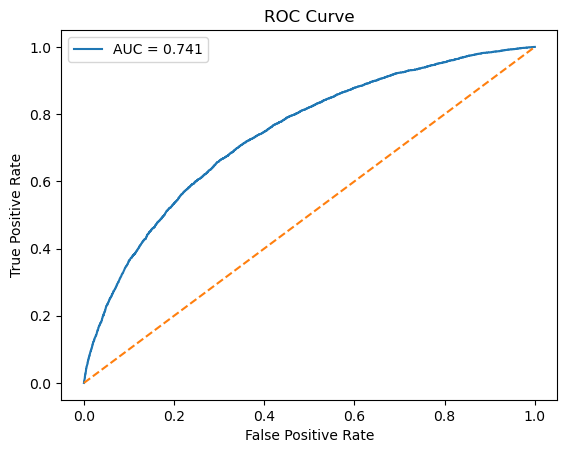

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label="AUC = %.3f" % roc_auc)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()